In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'segnet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 777.75it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    optimizer.zero_grad(set_to_none=True)
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score)
                TrainLoss_list1.append(unet_loss)
                valScore_list2.append(segnet_val_score)
                TrainLoss_list2.append(segnet_loss)                
                valScore_list3.append(enet_val_score)
                TrainLoss_list3.append(enet_loss)
                valScore_list4.append(voting_val_score)
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:09<00:00, 41.70img/s]

***
segnet Loss: 0.7999230623245239


Epoch 1/50:  99%|█████████▊| 200/203 [00:11<00:00, 17.09img/s]


---
segnet Validation Dice Loss: 0.7054232358932495
segnet Validation Pixel Accuracy: 0.8484229372258771
segnet Validation MIoU: 0.42967139510222935
segnet Validation Dice Score: 0.022993994876742363


Epoch 2/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.41img/s]

***
segnet Loss: 0.41059449315071106


Epoch 2/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.64img/s]


---
segnet Validation Dice Loss: 0.5086690187454224
segnet Validation Pixel Accuracy: 0.8867243716591283
segnet Validation MIoU: 0.6139959767889438
segnet Validation Dice Score: 0.5400890111923218


Epoch 3/50:  99%|█████████▊| 200/203 [00:07<00:00, 41.44img/s]

***
segnet Loss: 0.35305148363113403


Epoch 3/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.29img/s]


---
segnet Validation Dice Loss: 0.3292555809020996
segnet Validation Pixel Accuracy: 0.9186211301569354
segnet Validation MIoU: 0.7423389899006989
segnet Validation Dice Score: 0.7605523467063904


Epoch 4/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.62img/s]

***
segnet Loss: 0.24042923748493195


Epoch 4/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.23img/s]


---
segnet Validation Dice Loss: 0.32507771253585815
segnet Validation Pixel Accuracy: 0.9344150476288378
segnet Validation MIoU: 0.7966503527151594
segnet Validation Dice Score: 0.8238314986228943


Epoch 5/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.51img/s]

***
segnet Loss: 0.36250317096710205


Epoch 5/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.95img/s]


---
segnet Validation Dice Loss: 0.27298128604888916
segnet Validation Pixel Accuracy: 0.9230282432154605
segnet Validation MIoU: 0.7794686253836838
segnet Validation Dice Score: 0.8127713203430176


Epoch 6/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.14img/s]

***
segnet Loss: 0.2194008231163025


Epoch 6/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.21img/s]


---
segnet Validation Dice Loss: 0.24001380801200867
segnet Validation Pixel Accuracy: 0.9421499151932565
segnet Validation MIoU: 0.8182199344742311
segnet Validation Dice Score: 0.8416083455085754


Epoch 7/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.32img/s]

***
segnet Loss: 0.15941449999809265


Epoch 7/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.80img/s]


---
segnet Validation Dice Loss: 0.2559545338153839
segnet Validation Pixel Accuracy: 0.9350208483244243
segnet Validation MIoU: 0.7997075889798828
segnet Validation Dice Score: 0.8336949348449707


Epoch 8/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.75img/s]

***
segnet Loss: 0.1709509789943695


Epoch 8/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.68img/s]


---
segnet Validation Dice Loss: 0.2238948941230774
segnet Validation Pixel Accuracy: 0.9424706174616229
segnet Validation MIoU: 0.8148799223598613
segnet Validation Dice Score: 0.8625764846801758


Epoch 9/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.83img/s]

***
segnet Loss: 0.11052567511796951


Epoch 9/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.07img/s]


---
segnet Validation Dice Loss: 0.201620414853096
segnet Validation Pixel Accuracy: 0.9505055745442709
segnet Validation MIoU: 0.8372071730880158
segnet Validation Dice Score: 0.8547728657722473


Epoch 10/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.05img/s]

***
segnet Loss: 0.14539431035518646


Epoch 10/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.83img/s]


---
segnet Validation Dice Loss: 0.21725356578826904
segnet Validation Pixel Accuracy: 0.9463375158477247
segnet Validation MIoU: 0.8276955037408624
segnet Validation Dice Score: 0.86361163854599


Epoch 11/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.04img/s]

***
segnet Loss: 0.10240308940410614


Epoch 11/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.80img/s]


---
segnet Validation Dice Loss: 0.20761370658874512
segnet Validation Pixel Accuracy: 0.9497081020422149
segnet Validation MIoU: 0.8378754222258672
segnet Validation Dice Score: 0.8800473213195801


Epoch 12/50:  99%|█████████▊| 200/203 [00:06<00:00, 39.83img/s]

***
segnet Loss: 0.09339842945337296


Epoch 12/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.02img/s]


---
segnet Validation Dice Loss: 0.17564719915390015
segnet Validation Pixel Accuracy: 0.9544744658888432
segnet Validation MIoU: 0.8500784590828605
segnet Validation Dice Score: 0.8919925093650818


Epoch 13/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.94img/s]

***
segnet Loss: 0.10330243408679962


Epoch 13/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.89img/s]


---
segnet Validation Dice Loss: 0.2140551209449768
segnet Validation Pixel Accuracy: 0.9474463211862665
segnet Validation MIoU: 0.8327587759611338
segnet Validation Dice Score: 0.8844569325447083


Epoch 14/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.97img/s]

***
segnet Loss: 0.09910766780376434


Epoch 14/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.38img/s]


---
segnet Validation Dice Loss: 0.1418602466583252
segnet Validation Pixel Accuracy: 0.9659595154879386
segnet Validation MIoU: 0.8817431872330965
segnet Validation Dice Score: 0.8948726654052734


Epoch 15/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.91img/s]

***
segnet Loss: 0.07803449034690857


Epoch 15/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.73img/s]


---
segnet Validation Dice Loss: 0.11409525573253632
segnet Validation Pixel Accuracy: 0.9724217465049342
segnet Validation MIoU: 0.9000473288847475
segnet Validation Dice Score: 0.8981987833976746


Epoch 16/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.13img/s]

***
segnet Loss: 0.09988878667354584


Epoch 16/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.61img/s]


---
segnet Validation Dice Loss: 0.205746591091156
segnet Validation Pixel Accuracy: 0.9512149743866503
segnet Validation MIoU: 0.8447091633803878
segnet Validation Dice Score: 0.8816960453987122


Epoch 17/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.92img/s]

***
segnet Loss: 0.05350290983915329


Epoch 17/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.34img/s]


---
segnet Validation Dice Loss: 0.15273889899253845
segnet Validation Pixel Accuracy: 0.9620886016310307
segnet Validation MIoU: 0.8707290388790493
segnet Validation Dice Score: 0.9105892181396484


Epoch 18/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.64img/s]

***
segnet Loss: 0.062412749975919724


Epoch 18/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.00img/s]


---
segnet Validation Dice Loss: 0.11004040390253067
segnet Validation Pixel Accuracy: 0.9727065772341009
segnet Validation MIoU: 0.9025712469667699
segnet Validation Dice Score: 0.914233386516571


Epoch 19/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.83img/s]

***
segnet Loss: 0.07669210433959961


Epoch 19/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.93img/s]


---
segnet Validation Dice Loss: 0.1418667882680893
segnet Validation Pixel Accuracy: 0.9652281644051535
segnet Validation MIoU: 0.8814752299497566
segnet Validation Dice Score: 0.9009998440742493


Epoch 20/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.73img/s]

***
segnet Loss: 0.04944499954581261


Epoch 20/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.72img/s]


---
segnet Validation Dice Loss: 0.16210463643074036
segnet Validation Pixel Accuracy: 0.9611412182188871
segnet Validation MIoU: 0.8658298783318557
segnet Validation Dice Score: 0.9000456929206848


Epoch 21/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.91img/s]

***
segnet Loss: 0.05797155201435089


Epoch 21/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.74img/s]


---
segnet Validation Dice Loss: 0.1527271419763565
segnet Validation Pixel Accuracy: 0.9628579658374452
segnet Validation MIoU: 0.8743893187937798
segnet Validation Dice Score: 0.9102458953857422


Epoch 22/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.77img/s]

***
segnet Loss: 0.041385844349861145


Epoch 22/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.91img/s]


---
segnet Validation Dice Loss: 0.1284419149160385
segnet Validation Pixel Accuracy: 0.9689248068290844
segnet Validation MIoU: 0.8917375330730062
segnet Validation Dice Score: 0.9176009297370911


Epoch 23/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.97img/s]

***
segnet Loss: 0.050663020461797714


Epoch 23/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.20img/s]


---
segnet Validation Dice Loss: 0.10724025964736938
segnet Validation Pixel Accuracy: 0.9739334374143366
segnet Validation MIoU: 0.9059321743854356
segnet Validation Dice Score: 0.9215888977050781


Epoch 24/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.02img/s]

***
segnet Loss: 0.036534518003463745


Epoch 24/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.67img/s]


---
segnet Validation Dice Loss: 0.1383122205734253
segnet Validation Pixel Accuracy: 0.9676419977556195
segnet Validation MIoU: 0.8882212279067594
segnet Validation Dice Score: 0.922249436378479


Epoch 25/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.48img/s]

***
segnet Loss: 0.043731316924095154


Epoch 25/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.11img/s]


---
segnet Validation Dice Loss: 0.15814892947673798
segnet Validation Pixel Accuracy: 0.9638342606393915
segnet Validation MIoU: 0.8786552382327831
segnet Validation Dice Score: 0.9139577746391296


Epoch 26/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.00img/s]

***
segnet Loss: 0.04282160848379135


Epoch 26/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.53img/s]


---
segnet Validation Dice Loss: 0.13241006433963776
segnet Validation Pixel Accuracy: 0.968536376953125
segnet Validation MIoU: 0.8907675387000527
segnet Validation Dice Score: 0.9240601658821106


Epoch 27/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.71img/s]

***
segnet Loss: 0.04102638363838196


Epoch 27/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.83img/s]


---
segnet Validation Dice Loss: 0.1313697248697281
segnet Validation Pixel Accuracy: 0.9696465207819354
segnet Validation MIoU: 0.8935037526722596
segnet Validation Dice Score: 0.9245893359184265


Epoch 28/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.97img/s]

***
segnet Loss: 0.04171182960271835


Epoch 28/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.04img/s]


---
segnet Validation Dice Loss: 0.16144618391990662
segnet Validation Pixel Accuracy: 0.9633060923793859
segnet Validation MIoU: 0.8766690342940211
segnet Validation Dice Score: 0.9174076914787292


Epoch 29/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.95img/s]

***
segnet Loss: 0.03865671157836914


Epoch 29/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.85img/s]


---
segnet Validation Dice Loss: 0.15082068741321564
segnet Validation Pixel Accuracy: 0.965676558645148
segnet Validation MIoU: 0.8835016080672545
segnet Validation Dice Score: 0.9207468032836914


Epoch 30/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.09img/s]

***
segnet Loss: 0.0370703749358654


Epoch 30/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.96img/s]


---
segnet Validation Dice Loss: 0.14668667316436768
segnet Validation Pixel Accuracy: 0.966434679533306
segnet Validation MIoU: 0.88556767155446
segnet Validation Dice Score: 0.9224416613578796


Epoch 31/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.73img/s]

***
segnet Loss: 0.036596350371837616


Epoch 31/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.78img/s]


---
segnet Validation Dice Loss: 0.12616267800331116
segnet Validation Pixel Accuracy: 0.9706627025938871
segnet Validation MIoU: 0.8970258532510151
segnet Validation Dice Score: 0.9247026443481445


Epoch 32/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.73img/s]

***
segnet Loss: 0.041471339762210846


Epoch 32/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.86img/s]


---
segnet Validation Dice Loss: 0.16897450387477875
segnet Validation Pixel Accuracy: 0.9628282513534814
segnet Validation MIoU: 0.8758986441381148
segnet Validation Dice Score: 0.9159917831420898


Epoch 33/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.92img/s]

***
segnet Loss: 0.043273091316223145


Epoch 33/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.73img/s]


---
segnet Validation Dice Loss: 0.11724031716585159
segnet Validation Pixel Accuracy: 0.9715886701617324
segnet Validation MIoU: 0.8993187939897013
segnet Validation Dice Score: 0.9233628511428833


Epoch 34/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.69img/s]

***
segnet Loss: 0.03457915782928467


Epoch 34/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.55img/s]


---
segnet Validation Dice Loss: 0.14735543727874756
segnet Validation Pixel Accuracy: 0.9661372669956141
segnet Validation MIoU: 0.8847155039395211
segnet Validation Dice Score: 0.9220256805419922


Epoch 35/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.80img/s]

***
segnet Loss: 0.03328952193260193


Epoch 35/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.86img/s]


---
segnet Validation Dice Loss: 0.13588091731071472
segnet Validation Pixel Accuracy: 0.969251130756579
segnet Validation MIoU: 0.892927154843044
segnet Validation Dice Score: 0.9251323938369751


Epoch 36/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.78img/s]

***
segnet Loss: 0.03801315277814865


Epoch 36/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.08img/s]


---
segnet Validation Dice Loss: 0.1373932957649231
segnet Validation Pixel Accuracy: 0.9679482443290844
segnet Validation MIoU: 0.8898935691173212
segnet Validation Dice Score: 0.9235086441040039


Epoch 37/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.84img/s]

***
segnet Loss: 0.03503260761499405


Epoch 37/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.83img/s]


---
segnet Validation Dice Loss: 0.12791159749031067
segnet Validation Pixel Accuracy: 0.9699811433490954
segnet Validation MIoU: 0.8951572909292
segnet Validation Dice Score: 0.9250003695487976


Epoch 38/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.95img/s]

***
segnet Loss: 0.027795450761914253


Epoch 38/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.66img/s]


---
segnet Validation Dice Loss: 0.1218310296535492
segnet Validation Pixel Accuracy: 0.9714154695209704
segnet Validation MIoU: 0.8995569727201378
segnet Validation Dice Score: 0.9257158637046814


Epoch 39/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.81img/s]

***
segnet Loss: 0.033181920647621155


Epoch 39/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.96img/s]


---
segnet Validation Dice Loss: 0.13504846394062042
segnet Validation Pixel Accuracy: 0.968674241450795
segnet Validation MIoU: 0.8918400702257088
segnet Validation Dice Score: 0.9227555394172668


Epoch 40/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.78img/s]

***
segnet Loss: 0.035291124135255814


Epoch 40/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.66img/s]


---
segnet Validation Dice Loss: 0.14987125992774963
segnet Validation Pixel Accuracy: 0.9664461905496162
segnet Validation MIoU: 0.8852285143767324
segnet Validation Dice Score: 0.9233803153038025


Epoch 41/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.96img/s]

***
segnet Loss: 0.02910885587334633


Epoch 41/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.99img/s]


---
segnet Validation Dice Loss: 0.134725421667099
segnet Validation Pixel Accuracy: 0.9691229033888432
segnet Validation MIoU: 0.8926526480398176
segnet Validation Dice Score: 0.9257540702819824


Epoch 42/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.07img/s]

***
segnet Loss: 0.03853713721036911


Epoch 42/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.87img/s]


---
segnet Validation Dice Loss: 0.10858459770679474
segnet Validation Pixel Accuracy: 0.9746262399773848
segnet Validation MIoU: 0.9090305900479454
segnet Validation Dice Score: 0.9271336793899536


Epoch 43/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.91img/s]

***
segnet Loss: 0.03565255552530289


Epoch 43/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.64img/s]


---
segnet Validation Dice Loss: 0.12762093544006348
segnet Validation Pixel Accuracy: 0.9704482764528509
segnet Validation MIoU: 0.8960173410094849
segnet Validation Dice Score: 0.9246570467948914


Epoch 44/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.00img/s]

***
segnet Loss: 0.02948630228638649


Epoch 44/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.27img/s]


---
segnet Validation Dice Loss: 0.1360192894935608
segnet Validation Pixel Accuracy: 0.9688155860231634
segnet Validation MIoU: 0.8923848801693607
segnet Validation Dice Score: 0.9238311052322388


Epoch 45/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.60img/s]

***
segnet Loss: 0.031175095587968826


Epoch 45/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.11img/s]


---
segnet Validation Dice Loss: 0.1548982858657837
segnet Validation Pixel Accuracy: 0.9656977067913926
segnet Validation MIoU: 0.883216015161857
segnet Validation Dice Score: 0.9214662909507751


Epoch 46/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.76img/s]

***
segnet Loss: 0.042351312935352325


Epoch 46/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.90img/s]


---
segnet Validation Dice Loss: 0.1163153350353241
segnet Validation Pixel Accuracy: 0.9727041679516173
segnet Validation MIoU: 0.902845385332973
segnet Validation Dice Score: 0.9274352192878723


Epoch 47/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.96img/s]

***
segnet Loss: 0.0394451767206192


Epoch 47/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.99img/s]


---
segnet Validation Dice Loss: 0.11982481181621552
segnet Validation Pixel Accuracy: 0.97212272777892
segnet Validation MIoU: 0.9013806047831081
segnet Validation Dice Score: 0.9262791872024536


Epoch 48/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.45img/s]

***
segnet Loss: 0.03749118745326996


Epoch 48/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.26img/s]


---
segnet Validation Dice Loss: 0.12773355841636658
segnet Validation Pixel Accuracy: 0.9700866163822642
segnet Validation MIoU: 0.8953188759439772
segnet Validation Dice Score: 0.9265546798706055


Epoch 49/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.95img/s]

***
segnet Loss: 0.04298572987318039


Epoch 49/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.22img/s]


---
segnet Validation Dice Loss: 0.1379055380821228
segnet Validation Pixel Accuracy: 0.9688436943188048
segnet Validation MIoU: 0.8919701086958837
segnet Validation Dice Score: 0.9255030751228333


Epoch 50/50:  99%|█████████▊| 200/203 [00:06<00:00, 40.19img/s]

***
segnet Loss: 0.04494611918926239


Epoch 50/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.83img/s]

---
segnet Validation Dice Loss: 0.11351782083511353
segnet Validation Pixel Accuracy: 0.9731530975877193
segnet Validation MIoU: 0.9039307645411203
segnet Validation Dice Score: 0.9259659051895142


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

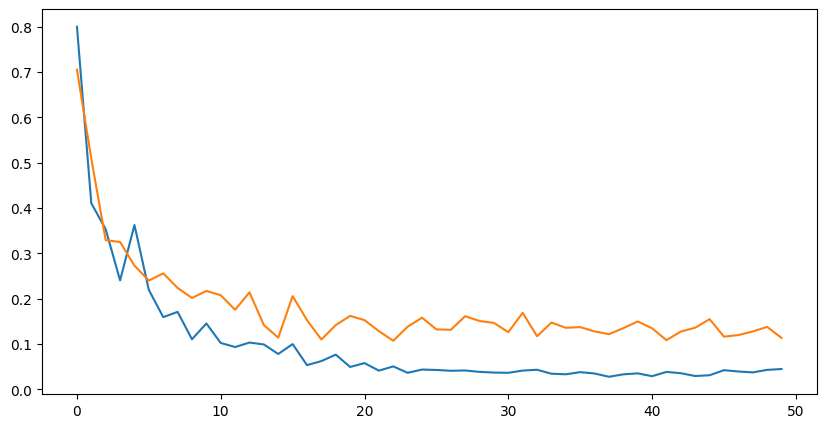

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)
#plt.show()

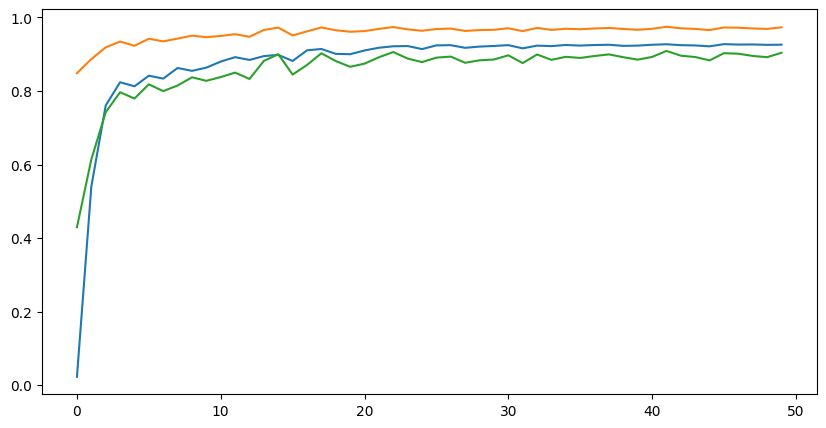

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)
#plt.show()